## Import the useful libraries

In [2]:
import os
import numpy as np 
import matplotlib.pyplot as plt
import cv2
import tensorflow as tf
from tensorflow.keras import applications
from tensorflow.keras import optimizers

## Run the following funtions below, they will be used

## (Add path to the dataset)

In [3]:
def generate_training_data(categories, crop_size):
    for category in categories:
        path = os.path.join("C:\\Users\\3C HOUSE\Desktop\Deeplearning\kvasir-dataset-v2" , category)
        # this is the path to the dataset in my pc, if you are a windows user you can ediit this path this is a basic format 
        # for a windows pc, if you are a mac or linux user you have to follow this format "/home/username/main_dir/sub_dir"
        class_number = categories.index(category)
        for img in os.listdir(path):
            try:
                img_array = cv2.imread( os.path.join ( path, img))
                resized_array = cv2.resize(img_array, (crop_size , crop_size) )
                training_data.append([resized_array,class_number])
            except Exception as e:    
                print(e)


In [4]:
def reshape_images(image_size):
    x,y = [], []
    for features,label in training_data:
        x.append(features)
        y.append(label)
    x = np.array(x).reshape(8000, image_size, image_size, 3)
    return x,y

In [5]:
categories = ['dyed-lifted-polyps','dyed-resection-margins','esophagitis',
             'normal-cecum','normal-pylorus','normal-z-line','polyps','ulcerative-colitis']

## Resize the images using opencv

In [6]:
training_data = []
generate_training_data(categories, 224)

## Convert the image to numpy arrays and resize them

In [10]:
x , y = reshape_images(224)

## Split data set (80% for training and 20% for testing)

In [11]:
from sklearn.model_selection import train_test_split
x_train,x_test,y_train,y_test = train_test_split(x,y,test_size=0.2,random_state=42)

## Preprocess dataset by scaling all pixel intensities to the range [0, 1]

In [12]:
x_train =x_train.astype('float32')
x_test =x_test.astype('float32')
x_train /= 255 #add a comment here
x_test /= 255

## Perform one hot encoding to categorize

In [13]:
y_train = tf.keras.utils.to_categorical(y_train, 8) # perform one hot encoding
y_test = tf.keras.utils.to_categorical(y_test, 8)

## Initializing ResNet50 model for transfer learning

In [31]:
model_ResNet50 = applications.ResNet50(weights = "imagenet", include_top=False, input_shape = (224, 224, 3))

## All the variables in first 173 layers (this ResNet CNNl has 22 layers) will not train

In [33]:
for layer in model_ResNet50.layers[:173]:
    layer.trainable = False

## This is ResNet50  model looks like , and do not need to remove any layers

In [34]:
model_ResNet50.summary()

Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_3[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
___________________________________________________________________________________________

## Adding global average pooling (GAP) layer to the ResNet50

In [35]:
x_ResNet50 = model_ResNet50.output
x_ResNet50 = tf.keras.layers.GlobalAveragePooling2D()(x_ResNet50)

## Adding batch normalizaton, dropout (for regularization), SoftMax, Adam as optimizer and categorical_crossentropy as loss function

In [36]:
x_ResNet50 = tf.keras.layers.BatchNormalization()(x_ResNet50)
x_ResNet50 = tf.keras.layers.Dropout(0.5)(x_ResNet50)
x_ResNet50 = tf.keras.layers.Dense(256, activation="relu")(x_ResNet50)
x_ResNet50 = tf.keras.layers.BatchNormalization()(x_ResNet50)
predictions = tf.keras.layers.Dense(8, activation="softmax")(x_ResNet50)   
model_final = tf.keras.models.Model(model_ResNet50.input, predictions)
model_final.compile(loss="categorical_crossentropy", optimizer='Adam', metrics=["accuracy"])

## Final model 

In [37]:
model_final.summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_3[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
____________________________________________________________________________________________

In [38]:
history=model_final.fit(x_train, y_train,
          batch_size=64,
          epochs=5,
          verbose=1,
          validation_data=(x_test, y_test))

Epoch 1/5
100/100 [==============================] - 917s 9s/step - loss: 1.5779 - accuracy: 0.4193 - val_loss: 2.0058 - val_accuracy: 0.1475
Epoch 2/5
100/100 [==============================] - 840s 8s/step - loss: 1.0440 - accuracy: 0.5725 - val_loss: 1.8061 - val_accuracy: 0.2431
Epoch 3/5
100/100 [==============================] - 872s 9s/step - loss: 0.9985 - accuracy: 0.5764 - val_loss: 1.5449 - val_accuracy: 0.3631
Epoch 4/5
100/100 [==============================] - 918s 9s/step - loss: 0.9194 - accuracy: 0.6109 - val_loss: 1.2184 - val_accuracy: 0.5081
Epoch 5/5
100/100 [==============================] - 854s 9s/step - loss: 0.9035 - accuracy: 0.6269 - val_loss: 1.0540 - val_accuracy: 0.5838


In [39]:
testscore = model_final.evaluate(x_test, y_test, verbose=0)

In [40]:
print('Test loss:', testscore[0])
print('Test accuracy:', testscore[1])

Test loss: 1.0539883375167847
Test accuracy: 0.5837500095367432


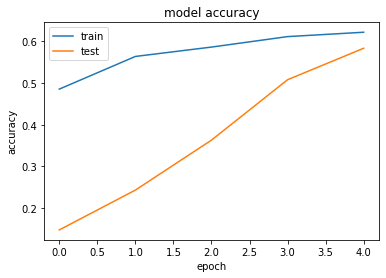

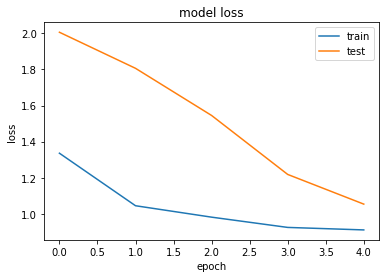

In [41]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()